<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, pcmdpy as ppy
from astropy.io import fits
import pickle


import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from photutils.isophote import EllipseGeometry, Ellipse
from photutils import EllipticalAperture
from photutils.isophote import build_ellipse_model
from photutils.isophote import EllipseSample, Isophote, IsophoteList
from photutils.isophote.isophote import Isophote, IsophoteList
import pyregion
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

GPU acceleration not available, sorry
No module named 'pycuda'


In [2]:
plt.style.use('seaborn-poster')

In [407]:
f = ppy.instrument.default_m49_filters()

In [408]:
iso_model = ppy.isochrones.Isochrone_Model(f, dm_interp=-1)

In [5]:
id_map = fits.open('../data/m49_isophot_ids.fits')['IDS'].data

In [6]:
im_shape = id_map.shape

In [323]:
m49_data = ppy.utils.DataSet(['../data/hst_9401_01_acs_wfc_f850lp_drz.fits', '../data/hst_9401_01_acs_wfc_f475w_drz.fits'],
                            ppy.instrument.m49_filter_sets)

In [327]:
sky_est_cps = [0.05, 0.008]
sky_est_counts = [f_._exposure*s for f_,s in zip(f, sky_est_cps)]

In [328]:
sky_est_counts

[60.5, 6.0]

In [364]:
[f_.counts_to_mag(s) for f_,s in zip(f, sky_est_counts)]

[27.595574989159953, 31.416875032520142]

In [365]:
-2.5*np.log10(2)

-0.752574989159953

In [331]:
sky_subtracted = [.8108564*3, .43659*2]
sky_sub_cps = [s/f_._exposure for f_,s in zip(f, sky_subtracted)]

In [332]:
sky_sub_cps

[0.0020103877685950415, 0.00116424]

In [301]:
sky_corrections = [-0.05, -0.008]
sky_subtracted = [.81085642178854, 0.4365965723991451]

In [333]:
# m49_data.images[:,:,0] += sky_corrections[0]
# m49_data.images[:,:,1] += sky_corrections[1]
m49_data.images[:,:,0] += sky_sub_cps[0]
m49_data.images[:,:,1] += sky_sub_cps[1]

In [335]:
with fits.open('../data/hst_9401_01_acs_wfc_f850lp_drz.fits') as hdu:
    im_F850LP = (hdu['SCI'].data + sky_sub_cps[0]) * f[0]._exposure
    mask_F850LP = (hdu['WHT'].data <= 0.)
    header_F850LP = hdu['PRIMARY'].header

In [336]:
with fits.open('../data/hst_9401_01_acs_wfc_f475w_drz.fits') as hdu:
    im_F475W = (hdu['SCI'].data + sky_sub_cps[1]) * f[1]._exposure
    mask_F475W = (hdu['WHT'].data <= 0.)
    header_F475W = hdu['PRIMARY'].header

In [337]:
mask = mask_F850LP + mask_F475W
mask += (im_F475W <= 0.)
mask += (im_F850LP <= 0.)
star_cutout = pyregion.open('../data/star_large.reg').as_imagecoord(header=header_F850LP).get_mask(shape=im_shape)
mask += star_cutout

In [338]:
results = np.loadtxt('../data/hst_9401_01_acs_wfc_f475w_daophot_trm.cat', unpack=True)
x1 = results[0]
y1 = results[1]

In [339]:
results = np.loadtxt('../data/hst_9401_01_acs_wfc_f850lp_daophot_trm.cat', unpack=True)
x2 = results[0]
y2 = results[1]

In [340]:
def get_cutout(r):
    cutout = np.zeros((21,21)).astype(bool)
    for i in range(-r, r+1):
        for j in range(-r, r+1):
            if np.sqrt(i**2 + j**2) <= r:
                cutout[10+i,10+j] = True
    return cutout

def cutout_sources(xs, ys, r=10):
    manual_mask = np.zeros(im_shape).astype(bool)
    cutout = get_cutout(r)
    for x, y in tqdm(zip(xs, ys)):
        x_ = int(np.round(x))
        y_ = int(np.round(y))
        manual_mask[y_-10:y_+11, x_-10:x_+11] = cutout
    return manual_mask

In [53]:
dao_mask = cutout_sources(x1, y1, r=10) + cutout_sources(x2, y2, r=10)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [341]:
manual_mask = pyregion.open('../data/m49_manual_sources.reg').as_imagecoord(header=header_F850LP).get_mask(shape=im_shape)

In [342]:
zero_mask = (id_map == 0)
negone_mask = (id_map == -1)
id_map[dao_mask] = -2
id_map[manual_mask] = -3
# id_map[bad_sky_mask] = -4

In [22]:
c_max = np.max(id_map)

In [23]:
isolist_F850LP = pickle.load(open("../data/isolist_F850LP.p", 'rb'))

In [24]:
isolist_F475W = pickle.load(open("../data/isolist_F475W.p", 'rb'))

In [54]:
def make_aper(x0, y0, sma, eps, pa):
    return EllipticalAperture((x0, y0), sma, sma*(1-eps), pa)

In [85]:
def make_aper_from_iso(iso):
    return make_aper(iso.x0, iso.y0, iso.sma, iso.eps, iso.pa)

In [55]:
def get_ellip_mask(im_shape, aper):
    aper_mask = aper.to_mask()[0]
    iso_mask = aper_mask.data.astype(bool)
    xmin = aper_mask.bbox.ixmin
    xmax = aper_mask.bbox.ixmax
    ymin = aper_mask.bbox.iymin
    ymax = aper_mask.bbox.iymax
    if (xmin < 0):
        dx = np.abs(xmin)
        xmin = 0
        iso_mask = iso_mask[:,dx:]
    if (xmax > im_shape[1]-1):
        dx = np.abs(xmax - im_shape[1] + 1)
        xmax = im_shape[1]-1
        iso_mask = iso_mask[:,:-dx]
    if (ymin < 0):
        dy = np.abs(ymin)
        ymin = 0
        iso_mask = iso_mask[dy:,:]
    if (ymax > im_shape[0]-1):
        dy = np.abs(ymax - im_shape[0] + 1)
        ymax = im_shape[0]-1
        iso_mask = iso_mask[:-dy,:]
    final_mask = np.zeros(im_shape).astype(bool)
    final_mask[ymin:ymax, xmin:xmax] = iso_mask
    return final_mask

In [59]:
def interp_aper(iso1, iso2, f):
    assert 0. <= f <= 1.
    x = f*iso2.x0 + (1-f)*iso1.x0
    y = f*iso2.y0 + (1-f)*iso1.y0
    sma = f*iso2.sma + (1-f)*iso1.sma
    eps = f*iso2.eps + (1-f)*iso1.eps
    pa = f*iso2.pa + (1-f)*iso1.pa
    return make_aper(x, y, sma, eps, pa)

In [60]:
isolist_F850LP.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
4.305676431342452,26791.012573712072,24.21194061569563,0.23881967508904456,0.010944287324729404,111.38323144993227,1.5543759406114155,0.26024033821131326,24,0,10,0
4.736244074476697,26689.24867513188,25.798719571377138,0.26164748452085573,0.011106390280103212,107.64002408350102,1.4617230688655236,0.29146785541582726,26,0,10,0
5.209868481924367,26603.07867525197,27.409544739790825,0.2959030019410865,0.011514330017133404,103.86769666110638,1.3768783055964022,0.33003795333066743,28,0,10,0
5.730855330116804,26536.57025892213,30.45453423387474,0.33511917845719535,0.011493265698500524,100.78371568888919,1.2517387666026771,0.33899213109491594,30,0,10,0
6.303940863128485,26438.991587014156,28.350513689120152,0.3583486058276064,0.007998825728637197,98.93221744688074,0.8162966096656452,0.24389728070597766,32,0,10,0
6.934334949441334,26230.156899374757,23.847826675406793,0.3041458250368182,0.011064524180489413,96.97021667370154,1.290088754625126,0.3522096872815864,37,0,10,0
7.627768444385468,26106.786277192907,19.55091809919439,0.2644119126434403,0.007849185057912338,96.23630791248472,0.9925287031762025,0.23690586285015766,41,0,10,0
8.390545288824015,26013.434284902658,19.183206050784385,0.28044649912150516,0.007533774828486318,102.11379411348398,0.9208246606716763,0.25619762415024794,45,0,10,0


In [61]:
mags_z = f[0].counts_to_mag(isolist_F850LP.intens)
mags_g = f[1].counts_to_mag(isolist_F475W.intens)

In [62]:
Neff = [np.sqrt(np.sum(id_map == i)) for i in range(1, c_max+1)]

In [111]:
Neff_min = 200
Neff_max = 400
mag_tol = 0.2

In [113]:
all_apers = [make_aper_from_iso(iso) for iso in isolist_F850LP]

In [114]:
id_map_interp = np.copy(id_map).astype(float)
# chop up regions into sub-chunks of max size Neff_max
for i in range(1, c_max+1):
    if Neff[i-1] >= Neff_max:
        num_sub = int(1 + (Neff[i-1]**2 // Neff_max**2))
        sub_fracs = np.linspace(0, 1, num_sub+1)[1:]
        prev_mask = get_ellip_mask(im_shape, all_apers[i-1])
        iso_start = isolist_F850LP[i-1]
        iso_end = isolist_F850LP[i]
        for d in range(num_sub):
            print(i, num_sub, d)
            f = sub_fracs[d]
            aper = interp_aper(iso_start, iso_end, f)
            this_mask = get_ellip_mask(im_shape, aper)
            id_map_interp[np.logical_and(this_mask, ~prev_mask)] += d / 100.
            prev_mask = this_mask

53 2 0
53 2 1
54 2 0
54 2 1
55 2 0
55 2 1
56 2 0
56 2 1
57 3 0
57 3 1
57 3 2
58 3 0
58 3 1
58 3 2
59 4 0
59 4 1
59 4 2
59 4 3
60 4 0
60 4 1
60 4 2
60 4 3
61 5 0
61 5 1
61 5 2
61 5 3
61 5 4
62 6 0
62 6 1
62 6 2
62 6 3
62 6 4
62 6 5
63 7 0
63 7 1
63 7 2
63 7 3
63 7 4
63 7 5
63 7 6
64 8 0
64 8 1
64 8 2
64 8 3
64 8 4
64 8 5
64 8 6
64 8 7
65 9 0
65 9 1
65 9 2
65 9 3
65 9 4
65 9 5
65 9 6
65 9 7
65 9 8
66 11 0
66 11 1
66 11 2
66 11 3
66 11 4
66 11 5
66 11 6
66 11 7
66 11 8
66 11 9
66 11 10
67 11 0
67 11 1
67 11 2
67 11 3
67 11 4
67 11 5
67 11 6
67 11 7
67 11 8
67 11 9
67 11 10
68 9 0
68 9 1
68 9 2
68 9 3
68 9 4
68 9 5
68 9 6
68 9 7
68 9 8


IndexError: list index out of range

In [165]:
id_map_interp[zero_mask] = 0.
id_map_interp[negone_mask] = -1.
id_map_interp[dao_mask] = -2.
id_map_interp[manual_mask] = -3.
id_map_interp[bad_sky_mask] = -4.

In [140]:
sorted(np.unique(id_map_interp))

[-4.0,
 -3.0,
 -2.0,
 -1.0,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.01,
 54.02,
 55.01,
 55.02,
 56.01,
 56.02,
 57.01,
 57.02,
 58.01,
 58.02,
 58.03,
 59.01,
 59.02,
 59.03,
 60.01,
 60.02,
 60.03,
 60.04,
 61.01,
 61.02,
 61.03,
 61.04,
 62.01,
 62.02,
 62.03,
 62.04,
 62.05,
 63.01,
 63.02,
 63.03,
 63.04,
 63.05,
 63.06,
 64.01,
 64.02,
 64.03,
 64.04,
 64.05,
 64.06,
 64.07,
 65.01,
 65.02,
 65.03,
 65.04,
 65.05,
 65.06,
 65.07,
 65.08,
 66.01,
 66.02,
 66.03,
 66.04,
 66.05,
 66.06,
 66.07,
 66.08,
 66.09,
 67.01,
 67.02,
 67.03,
 67.04,
 67.05,
 67.06,
 67.07,
 67.08,
 67.09,
 67.1,
 67.11,
 68.01,
 68.02,
 68.03,
 68.04,
 68.05,
 68.06,
 68.07,
 68.0

In [141]:
Neff = {}
for c in np.unique(id_map_interp):
    Neff[c] = np.sqrt(np.sum(id_map_interp == c))

In [128]:
Neff

{-4.0: 4.242640687119285,
 -3.0: 210.12853209404952,
 -2.0: 495.4230515428203,
 -1.0: 1170.9026432628802,
 0.0: 3888.002957817805,
 1.0: 7.810249675906654,
 2.0: 2.6457513110645907,
 3.0: 3.0,
 4.0: 3.605551275463989,
 5.0: 3.1622776601683795,
 6.0: 5.744562646538029,
 7.0: 5.477225575051661,
 8.0: 5.0,
 9.0: 6.164414002968976,
 10.0: 7.280109889280518,
 11.0: 6.928203230275509,
 12.0: 8.774964387392123,
 13.0: 8.12403840463596,
 14.0: 9.746794344808963,
 15.0: 11.832159566199232,
 16.0: 13.601470508735444,
 17.0: 14.422205101855956,
 18.0: 15.937377450509228,
 19.0: 17.97220075561143,
 20.0: 18.627936010197157,
 21.0: 20.92844953645635,
 22.0: 22.22611077089287,
 23.0: 24.839484696748443,
 24.0: 28.478061731796284,
 25.0: 30.4138126514911,
 26.0: 33.45145736735546,
 27.0: 36.9729630946723,
 28.0: 41.048751503547585,
 29.0: 44.57577817604534,
 30.0: 50.38849074937649,
 31.0: 52.392747589718944,
 32.0: 59.682493245507096,
 33.0: 64.74565622495459,
 34.0: 70.46985170979147,
 35.0: 77.446

(-191.62210901427244, 500)

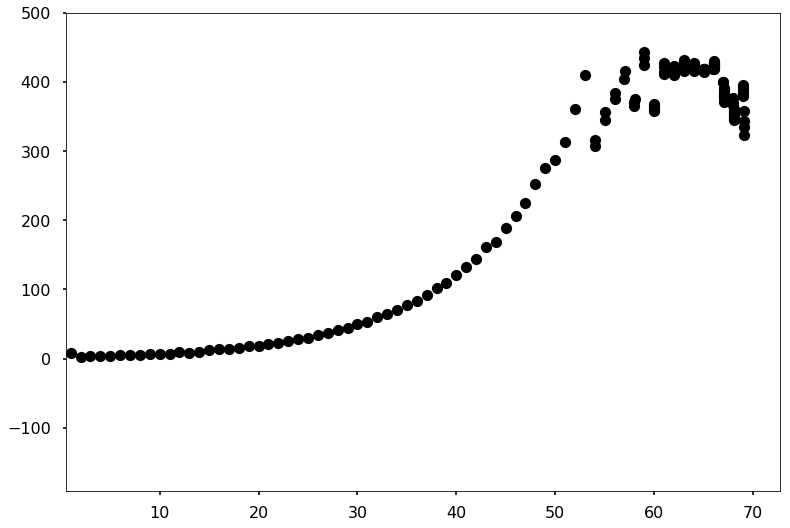

In [135]:
for k, v in Neff.items():
    plt.plot(k, v, 'ko')
plt.xlim(xmin=0.5)
plt.ylim(ymax=500)

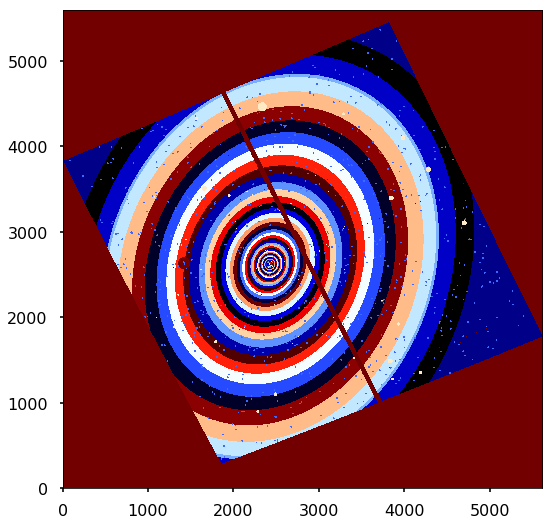

In [136]:
plt.imshow(id_map_interp, origin='lower', cmap='flag')

In [145]:
pcmd_regions = {}
Neffs_final = {}
temp_region = []
Neff_temp = 0.
k = 1
for i in sorted(np.unique(id_map_interp)):
    if i <= 0.:
        continue
    temp_region += [i]
    Neff_temp = np.sqrt(Neff_temp**2 + Neff[i]**2)
    if Neff_temp < Neff_min:
        continue
    else:
        pcmd_regions[k] = temp_region
        Neffs_final[k] = Neff_temp
        k += 1
        temp_region = []
        Neff_temp = 0.

In [146]:
Neffs_final

{1: 205.94659501919423,
 2: 212.67345861672538,
 3: 252.5292062316753,
 4: 252.90709756746645,
 5: 206.50423724466285,
 6: 224.5038975162792,
 7: 251.745903640953,
 8: 275.51406497672673,
 9: 287.74120316701254,
 10: 313.8072656902641,
 11: 361.1523224347311,
 12: 410.6957511345838,
 13: 307.14817271147814,
 14: 315.48692524413747,
 15: 344.4444802867365,
 16: 355.7695883574086,
 17: 374.7158923771448,
 18: 384.42814673225996,
 19: 404.80612643585323,
 20: 415.07710127155894,
 21: 364.78623877553275,
 22: 370.9636100751663,
 23: 374.89598557466576,
 24: 424.8717453538185,
 25: 434.1912021218302,
 26: 442.75614055594986,
 27: 358.86627035707886,
 28: 358.4787301919041,
 29: 363.61930641812734,
 30: 367.5663205463743,
 31: 411.4620274095776,
 32: 413.93356954951116,
 33: 421.5590112902344,
 34: 426.86766099108513,
 35: 409.4960317268044,
 36: 411.31010199118623,
 37: 414.9518044303459,
 38: 417.1306749688879,
 39: 422.62276322980995,
 40: 415.6284398353895,
 41: 420.45689434233327,
 42: 

In [147]:
pcmd_regions

{1: [1.0,
  2.0,
  3.0,
  4.0,
  5.0,
  6.0,
  7.0,
  8.0,
  9.0,
  10.0,
  11.0,
  12.0,
  13.0,
  14.0,
  15.0,
  16.0,
  17.0,
  18.0,
  19.0,
  20.0,
  21.0,
  22.0,
  23.0,
  24.0,
  25.0,
  26.0,
  27.0,
  28.0,
  29.0,
  30.0,
  31.0,
  32.0,
  33.0,
  34.0,
  35.0,
  36.0],
 2: [37.0, 38.0, 39.0, 40.0],
 3: [41.0, 42.0, 43.0],
 4: [44.0, 45.0],
 5: [46.0],
 6: [47.0],
 7: [48.0],
 8: [49.0],
 9: [50.0],
 10: [51.0],
 11: [52.0],
 12: [53.0],
 13: [54.01],
 14: [54.02],
 15: [55.01],
 16: [55.02],
 17: [56.01],
 18: [56.02],
 19: [57.01],
 20: [57.02],
 21: [58.01],
 22: [58.02],
 23: [58.03],
 24: [59.01],
 25: [59.02],
 26: [59.03],
 27: [60.01],
 28: [60.02],
 29: [60.03],
 30: [60.04],
 31: [61.01],
 32: [61.02],
 33: [61.03],
 34: [61.04],
 35: [62.01],
 36: [62.02],
 37: [62.03],
 38: [62.04],
 39: [62.05],
 40: [63.01],
 41: [63.02],
 42: [63.03],
 43: [63.04],
 44: [63.05],
 45: [63.06],
 46: [64.01],
 47: [64.02],
 48: [64.03],
 49: [64.04],
 50: [64.05],
 51: [64.06],


In [152]:
ids_final = np.copy(id_map)
for k in pcmd_regions.keys():
    for i in pcmd_regions[k]:
        ids_final[(id_map_interp == i)] = k

In [153]:
k_max = max(pcmd_regions.keys())
print('{:d} Regions'.format(k_max))

100 Regions


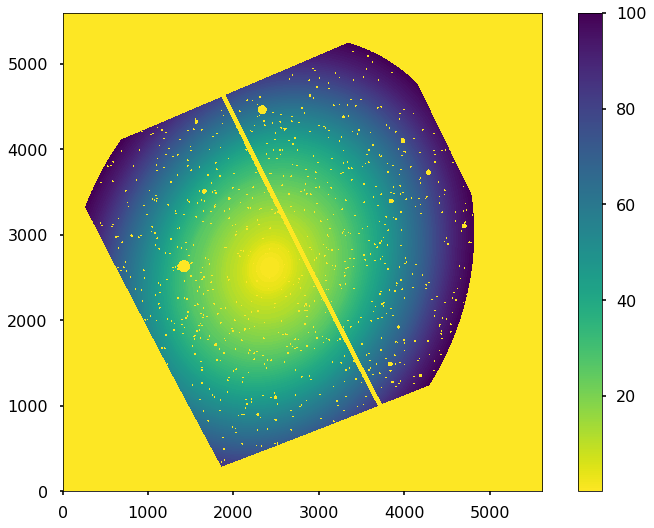

In [155]:
plt.imshow(ids_final, cmap='viridis_r', origin='lower', vmin=0.1)
plt.colorbar()

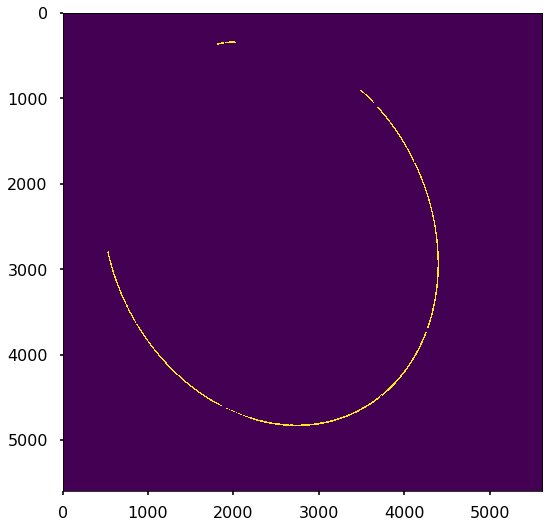

In [156]:
plt.imshow((ids_final == 80).astype(int))

In [171]:
np.unique(ids_final)

array([ -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,
         9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100])

In [157]:
hdu_p = fits.PrimaryHDU()
hdu_r = fits.ImageHDU(ids_final)
hdu_r.name = 'IDS'

hdul = fits.HDUList([hdu_p, hdu_r])
hdul.writeto('../data/m49_region_ids.fits', overwrite=True)

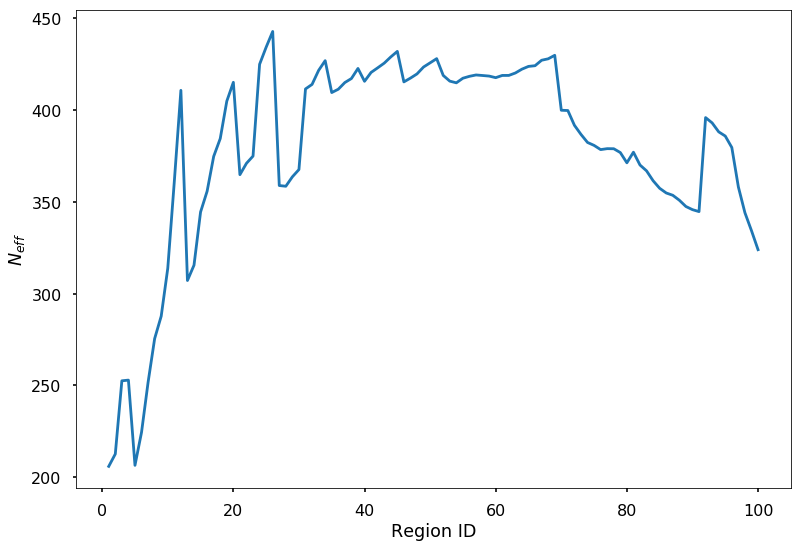

In [160]:
plt.plot(Neffs_final.keys(), Neffs_final.values())
plt.xlabel('Region ID'), plt.ylabel(r'$N_{eff}$');

In [161]:
def make_rgb_image(image):
    new_image = np.zeros((image.shape[0], image.shape[1], 3))
    new_image[:,:,0] = image[:,:,0]
    new_image[:,:,2] = image[:,:,1]
    new_image[:,:,1] = 0.5*(image[:,:,0] + image[:,:,1])
    return new_image

In [166]:
im_full = make_rgb_image(m49_data.get_image()[0])
im_full[mask + dao_mask + manual_mask + zero_mask + negone_mask] = 0.

In [167]:
bins = [np.arange(20, 30, 0.05), np.arange(-1, 4, 0.05)]

In [168]:
def showcase_region(rid, mag_noise=0., title=None):
    fig = plt.figure(figsize=(16, 10))
    gs0 = gridspec.GridSpec(2,3)
    ax1 = plt.subplot(gs0[:,1:])
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax2 = plt.subplot(gs0[0,0])
    ax2.yaxis.get_major_locator().set_params(nbins=2)
    ax2.xaxis.get_major_locator().set_params(nbins=2)
    ax3 = plt.subplot(gs0[1,0])

    b = (ids_final == rid)
    ys, xs = np.where(b)
    xlim = [min(xs), max(xs)]
    ylim = [min(ys), max(ys)]
    x1, x2 = xlim
    y1, y2 = ylim
    im, ext = m49_data.get_image(b)
    im = make_rgb_image(im)
    im = im_full[y1:y2,x1:x2, :]
    pcmd = m49_data.get_pcmd(b)

    ax1 = ppy.plotting.plot_rgb_image(im_full, extent=(0, im_full.shape[1], 0, im_full.shape[0]), ax=ax1, clip_vals=full_clip(99.))
    
    iso_outer = isolist_F850LP[pcmd_regions[rid-1][-1]]
    iso_inner = isolist_F850LP[pcmd_regions[rid-2][-1]]
    plt.subplot(ax2)
    for iso in [iso_outer, iso_inner]:
        aper = EllipticalAperture((iso.x0, iso.y0), iso.sma,
                                   iso.sma*(1 - iso.eps),
                                    iso.pa)
        aper.plot(color='red', lw=2)
    ax2 = ppy.plotting.plot_rgb_image(im, ax=ax2, clip_vals=full_clip(99.), extent=(x1, x2, y1, y2))
    mark_inset(ax1, ax2, loc1=1, loc2=3, ec='r', lw=1)
    ppy.plotting.plot_pcmd(pcmd, axes=ax3, bins=bins)
    ppy.plotting.plot_isochrone(iso_model, dmod=31.29, axes=ax3, zorder=-1)
    ax2.set_title('Region: {:d}, Neff: {:.1f}'.format(rid, Neffs[rid]))
    for a in [ax3]:
        a.set_ylim([32., 20.])
        if mag_noise > 0.:
            a.axhline(y=mag_noise, ls='--', color='r')
    if title is not None:
        ax2.set_title(title, fontsize=24)
    plt.tight_layout()

In [169]:
def full_clip(percentile):
    return np.array([np.percentile(im_full[:,:,i], percentile) for i in range(3)])

TypeError: list indices must be integers or slices, not numpy.float64

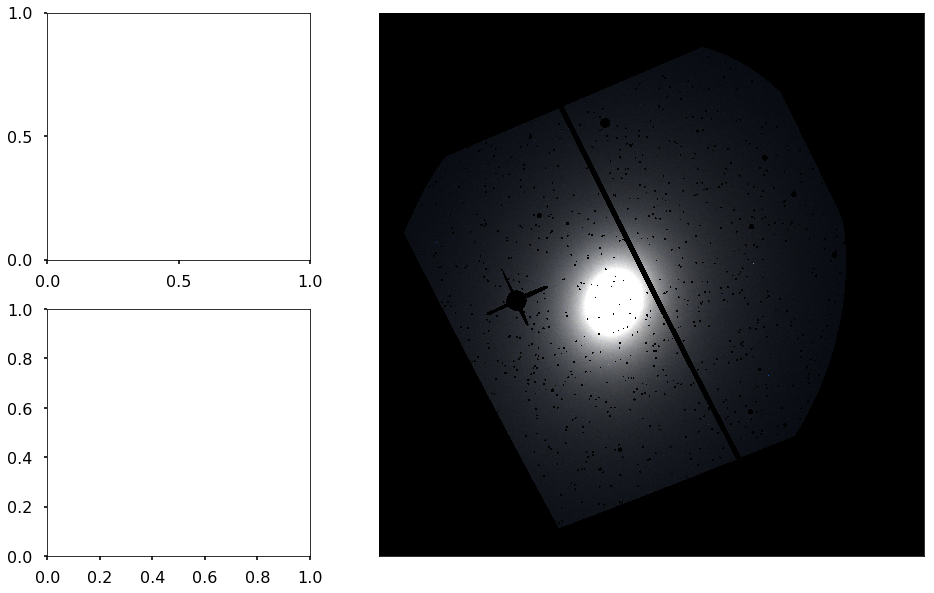

In [170]:
showcase_region(25)

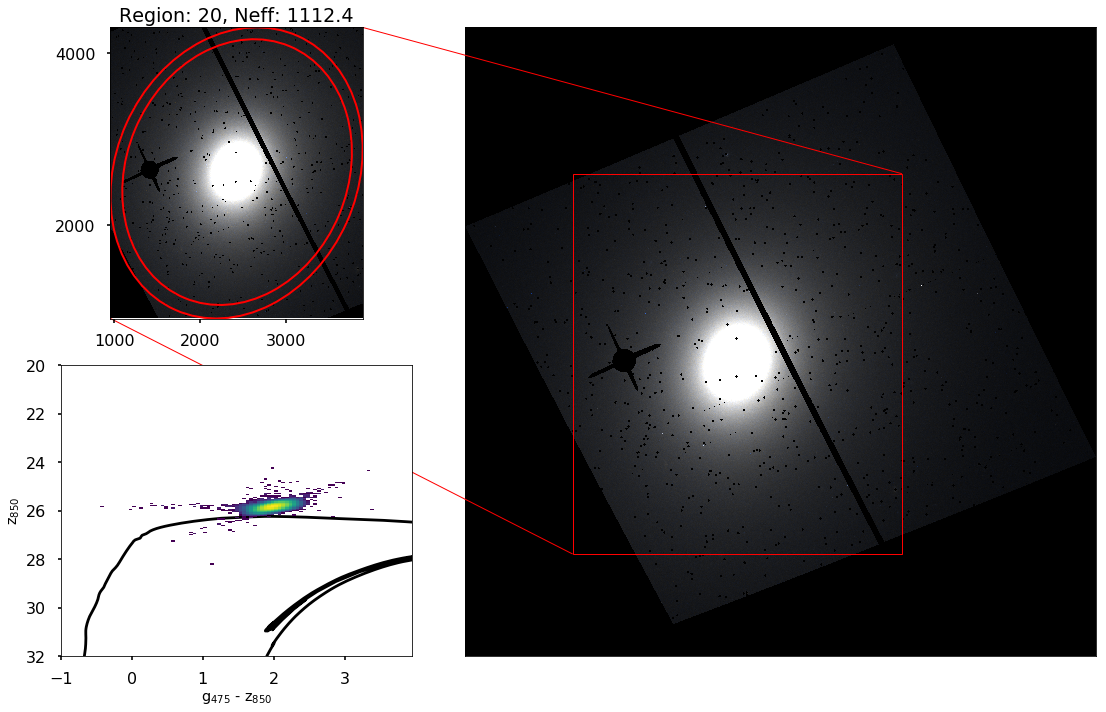

In [60]:
showcase_region(20)

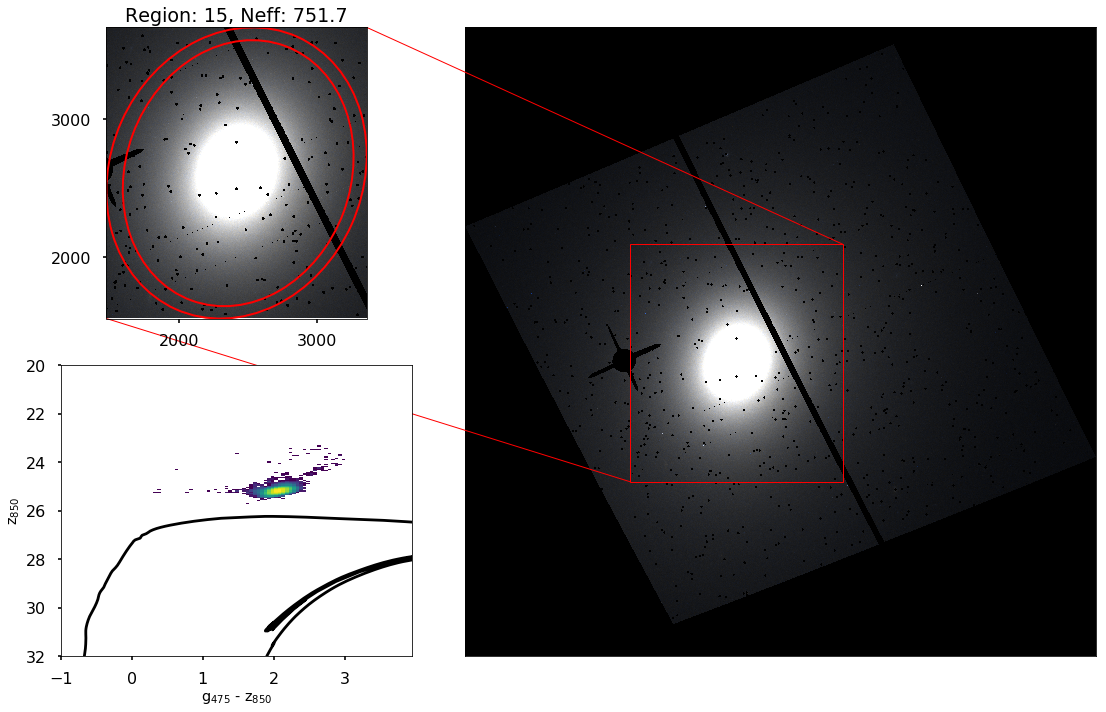

In [ ]:
showcase_region(15)

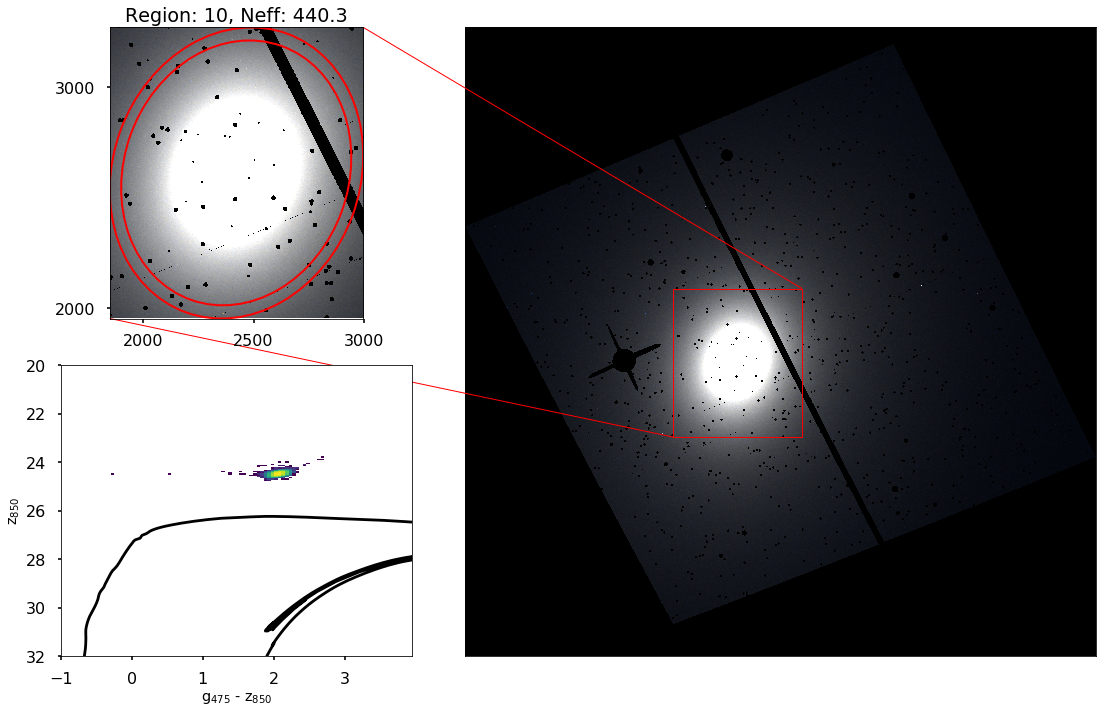

In [130]:
showcase_region(10)

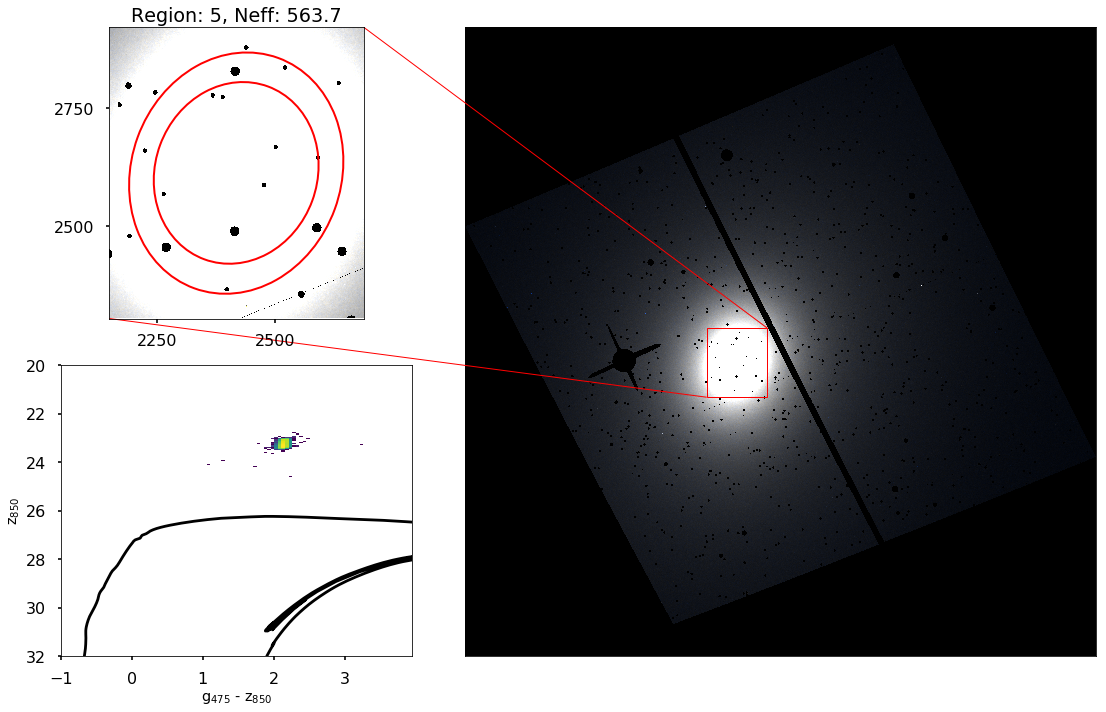

In [131]:
showcase_region(5)

/Users/bcook/.local/lib/python3.6/site-packages/pcmdpy/gpu_utils.py:209: RuntimeWarning: invalid value encountered in log10
  return np.log10(array_in)
/Users/bcook/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/bcook/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/bcook/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


(28, 20)

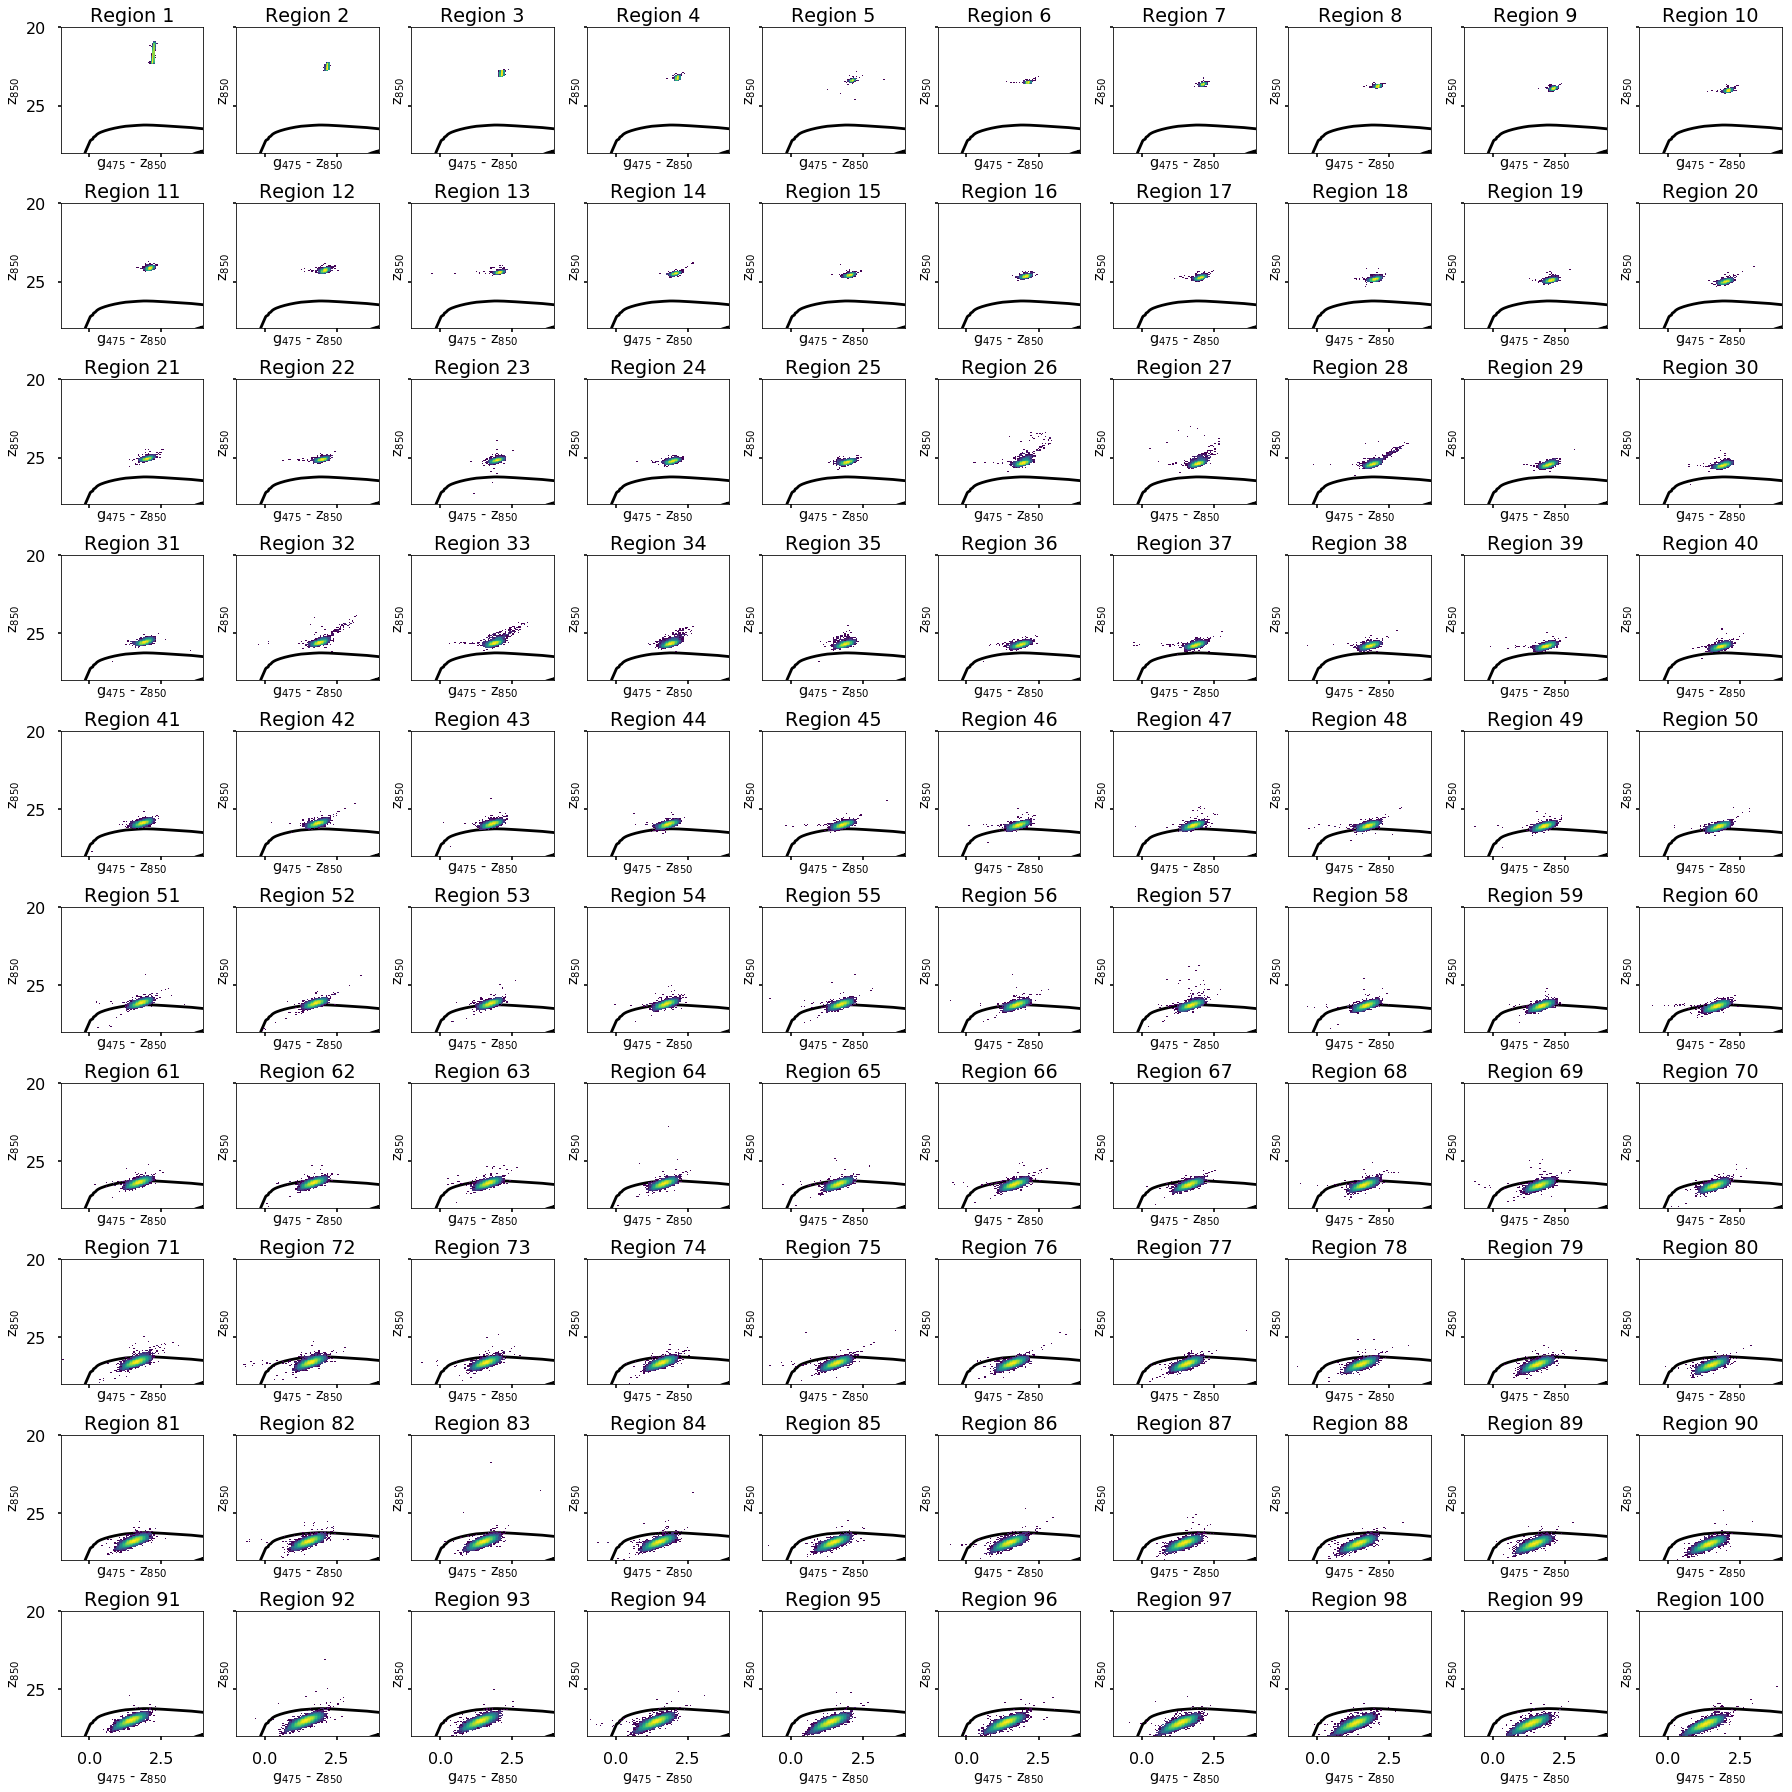

In [181]:
fig, axes = plt.subplots(ncols=10, nrows=10, figsize=(25, 25), sharex=True, sharey=True)
axes = axes.flatten()
for ax, k in zip(axes, list(pcmd_regions.keys())):
    ppy.plotting.plot_pcmd(m49_data.get_pcmd((ids_final == k)), bins=bins, axes=ax, title='Region {:d}'.format(k))
    ppy.plotting.plot_isochrone(iso_model, dmod=31.29, zorder=-1, axes=ax)
plt.tight_layout()
axes[0].set_ylim([28, 20])

In [179]:
def save_pcmd(k):
    this_mask = (ids_final == k)
    pcmd_data = m49_data.get_pcmd(this_mask)
    if k == 1:
        i_inner = 1
        sma_inner = 0.
    else:
        i_inner = pcmd_regions[k-1][-1]
        
        sma_inner = isolist_F850LP[i_inner].sma
    i_outer = pcmd_regions[k][-1]
    sma_outer = isolist_F850LP[i_outer].sma
    base_info = 'Vega Mags\n'
    base_info += 'Elliptical M49 region extracted from isophotes ({:.2f},{:.2f}]\n'.format(i_inner, i_outer)
#     base_info += 'Semi-Minor Axes (pix): ({:.1f}, {:.1f}]\n'.format(sma_inner, sma_outer)
    base_info += 'Num Pixels: {:d}\nNeff ~ {:.0f}^2\n'.format(np.sum(this_mask), Neffs_final[k])
    base_info += 'zmag gmag-zmag\nF850LP F475W-F850LP\n'
    filename = '../data/m49_r{:d}_z-gz.dat'.format(k)
    np.savetxt(filename, pcmd_data.T, fmt='%.6f', header=base_info)
    print('saved to: {:s}'.format(filename))

In [180]:
for k in range(1, k_max):
    save_pcmd(k)

saved to: ../data/m49_r1_z-gz.dat
saved to: ../data/m49_r2_z-gz.dat
saved to: ../data/m49_r3_z-gz.dat
saved to: ../data/m49_r4_z-gz.dat
saved to: ../data/m49_r5_z-gz.dat
saved to: ../data/m49_r6_z-gz.dat
saved to: ../data/m49_r7_z-gz.dat
saved to: ../data/m49_r8_z-gz.dat
saved to: ../data/m49_r9_z-gz.dat
saved to: ../data/m49_r10_z-gz.dat
saved to: ../data/m49_r11_z-gz.dat
saved to: ../data/m49_r12_z-gz.dat
saved to: ../data/m49_r13_z-gz.dat
saved to: ../data/m49_r14_z-gz.dat
saved to: ../data/m49_r15_z-gz.dat
saved to: ../data/m49_r16_z-gz.dat
saved to: ../data/m49_r17_z-gz.dat
saved to: ../data/m49_r18_z-gz.dat
saved to: ../data/m49_r19_z-gz.dat
saved to: ../data/m49_r20_z-gz.dat
saved to: ../data/m49_r21_z-gz.dat
saved to: ../data/m49_r22_z-gz.dat
saved to: ../data/m49_r23_z-gz.dat
saved to: ../data/m49_r24_z-gz.dat
saved to: ../data/m49_r25_z-gz.dat
saved to: ../data/m49_r26_z-gz.dat
saved to: ../data/m49_r27_z-gz.dat
saved to: ../data/m49_r28_z-gz.dat
saved to: ../data/m49_r29_z-g

/Users/bcook/.local/lib/python3.6/site-packages/pcmdpy/gpu_utils.py:209: RuntimeWarning: invalid value encountered in log10
  return np.log10(array_in)


saved to: ../data/m49_r48_z-gz.dat
saved to: ../data/m49_r49_z-gz.dat
saved to: ../data/m49_r50_z-gz.dat
saved to: ../data/m49_r51_z-gz.dat
saved to: ../data/m49_r52_z-gz.dat
saved to: ../data/m49_r53_z-gz.dat
saved to: ../data/m49_r54_z-gz.dat
saved to: ../data/m49_r55_z-gz.dat
saved to: ../data/m49_r56_z-gz.dat
saved to: ../data/m49_r57_z-gz.dat
saved to: ../data/m49_r58_z-gz.dat
saved to: ../data/m49_r59_z-gz.dat
saved to: ../data/m49_r60_z-gz.dat
saved to: ../data/m49_r61_z-gz.dat
saved to: ../data/m49_r62_z-gz.dat
saved to: ../data/m49_r63_z-gz.dat
saved to: ../data/m49_r64_z-gz.dat
saved to: ../data/m49_r65_z-gz.dat
saved to: ../data/m49_r66_z-gz.dat
saved to: ../data/m49_r67_z-gz.dat
saved to: ../data/m49_r68_z-gz.dat
saved to: ../data/m49_r69_z-gz.dat
saved to: ../data/m49_r70_z-gz.dat
saved to: ../data/m49_r71_z-gz.dat
saved to: ../data/m49_r72_z-gz.dat
saved to: ../data/m49_r73_z-gz.dat
saved to: ../data/m49_r74_z-gz.dat
saved to: ../data/m49_r75_z-gz.dat
saved to: ../data/m4

In [409]:
driv = ppy.driver.Driver(iso_model, gpu=False)

In [417]:
g = ppy.galaxy.TauSimple(np.array([0., -5., 4.8, 2.]), dmod=31.3)

In [426]:
f[0]._exposure = 90.
f[1]._exposure = 90.

In [430]:
%%time
sky_val = [f_._exposure*s for f_,s in zip(driv.iso_model.filters, sky_est_cps)]
pcmd_model, _ = driv.simulate(g, 200, downsample=5, shot_noise=True, sky_noise=sky_val)

CPU times: user 42.7 s, sys: 4.26 s, total: 46.9 s
Wall time: 49.1 s


In [431]:
sky_est_counts

[60.5, 6.0]

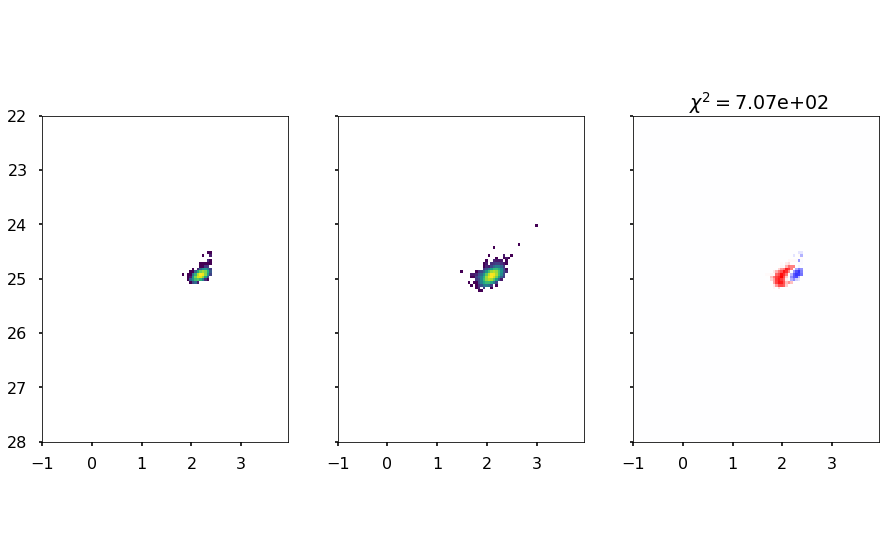

In [432]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 6), sharex=True, sharey=True)
pcmd_data = m49_data.get_pcmd((ids_final == 20))
ppy.plotting.plot_pcmd(pcmd_model, bins=bins, axes=axes[0])
ppy.plotting.plot_pcmd(pcmd_data, bins=bins, axes=axes[1])
ppy.plotting.plot_pcmd_residual(pcmd_model, pcmd_data, bins=bins, axes=axes[2], like_mode=1)
axes[0].set_ylim([28, 22]);

In [206]:
np.sqrt(len(pcmd_data[0]))

371.2438551680014

/Users/bcook/.local/lib/python3.6/site-packages/pcmdpy/plotting.py:31: RuntimeWarning: invalid value encountered in true_divide
  images[:, :, i] /= np.percentile(images[:, :, i], clip_percent)
/Users/bcook/.local/lib/python3.6/site-packages/pcmdpy/plotting.py:32: RuntimeWarning: invalid value encountered in less_equal
  images[images <= 0.] = 0.
/Users/bcook/.local/lib/python3.6/site-packages/pcmdpy/plotting.py:33: RuntimeWarning: invalid value encountered in greater_equal
  images[images >= 1.] = 1.


/Users/bcook/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


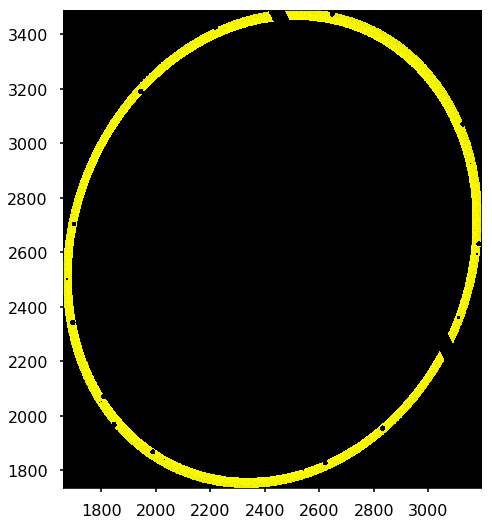

In [262]:
im, ext = m49_data.get_image((ids_final == 20))
ppy.plotting.plot_rgb_image(im, extent=ext)



In [397]:
intens = m49_data.images[(ids_final == 20)]

In [398]:
mag_z = f[0].counts_to_mag(f[0]._exposure * intens[:,0])
mag_g = f[1].counts_to_mag(f[1]._exposure * intens[:,1])

In [399]:
f[0]._exposure, f[1]._exposure

(134.44444444444443, 83.33333333333333)

(25.5, 24.5)

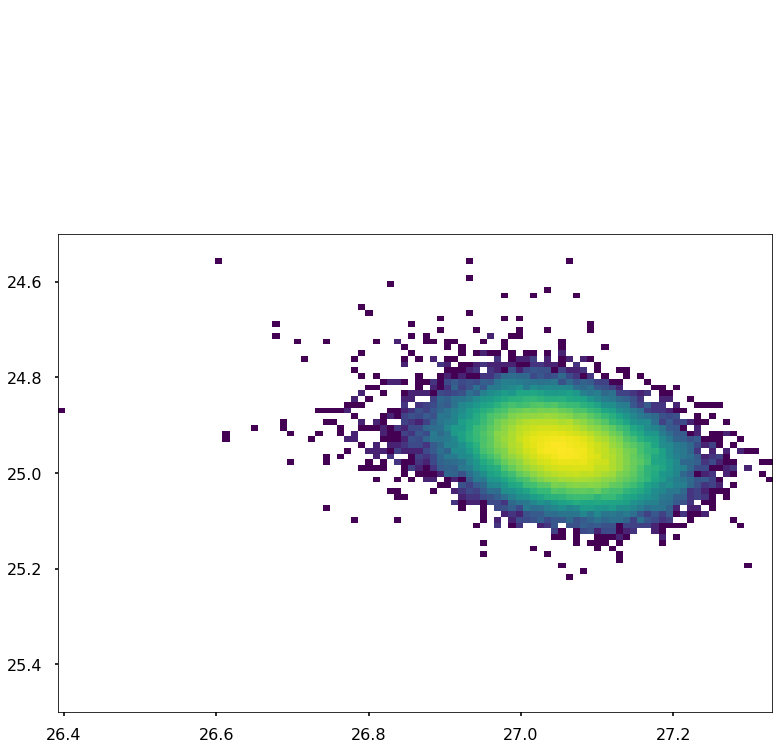

In [404]:
plt.hist2d(mag_g, mag_z, norm=mpl.colors.LogNorm(), bins=100);
plt.ylim([25.5, 24.5])

(25.5, 24.5)

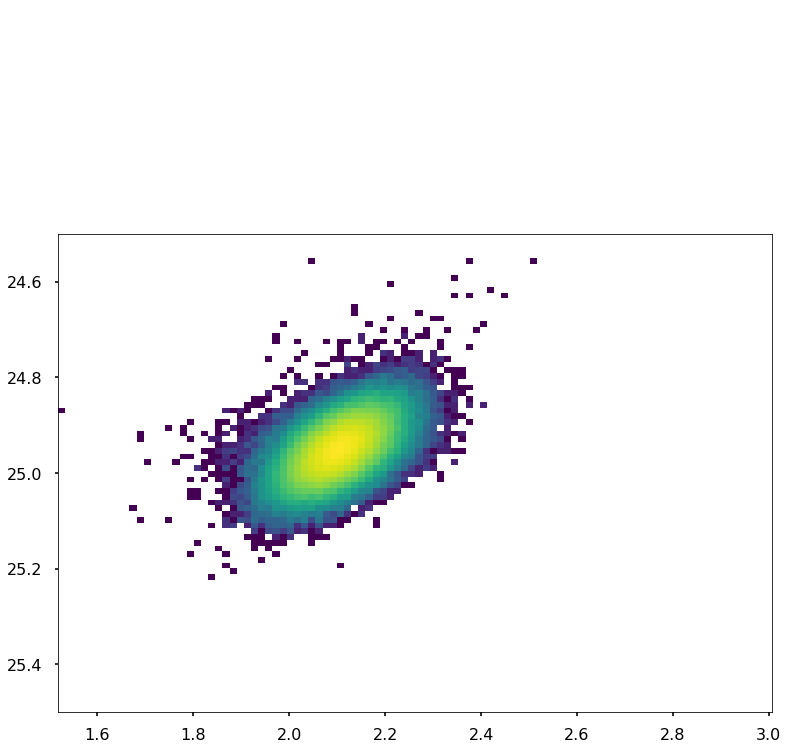

In [405]:
plt.hist2d(mag_g-mag_z, mag_z, norm=mpl.colors.LogNorm(), bins=100);
plt.ylim([25.5, 24.5])